In [1]:
import numpy as np
import pygame
from pygame.locals import QUIT, MOUSEBUTTONDOWN, KEYDOWN
import sys
import math
import matplotlib.pyplot as plt
from PyQt5.QtWidgets import QApplication, QMainWindow
from PyQt5.QtCore import Qt
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
import pygetwindow as gw
import pyaudio
import threading
import control
import param

pygame 2.6.1 (SDL 2.28.4, Python 3.12.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# Extracting constants from param module
L1, L2, m1, m2, I1, I2, g, dp, wheelradius = param.L1, param.L2, param.m1, param.m2, param.I1, param.I2, param.g, param.dp, param.wheelradius
J, Ng, ke, kt, R, L, B = param.J, param.Ng, param.ke, param.kt, param.R, param.L, param.B
Q_LQR, R_LQR, N_LQR = param.Q_LQR, param.R_LQR, param.N_LQR
StabilizeBound = param.StabilizeBound

In [3]:
# LQR (linear quadratic regulator) controller parameter
a = (m1 * L1 * L1) + (m2 * L2 * L2) + (I1)
b = (m1 * L1 + m2 * L2) * g

a21 = b/a
a24 = (kt * ke * Ng * Ng)/(a * R)
a41 = -b/a
a44 = -(a + J) * (kt * ke * Ng * Ng) /(a * J * R)

b2 = -(kt*Ng)/(a*R)
b4 = (a + J) * (kt * Ng)/(a * J * R)

A_matrix = np.array([[0, 1, 0, 0],
                     [a21, 0, 0, a24],
                     [0, 0, 0, 1],
                     [a41, 0, 0 , a44]])

B_Matrix = np.array([[0],
                     [b2],
                     [0],
                     [b4]])

desired_poles = []

In [4]:
# ==========================================================================================
# ======================================= FUNCTION =========================================
# ==========================================================================================
def Forwardkinematics(q):
    x = L2 * math.sin(q)
    y = L2 * math.cos(q)
    return x, y

def PendulumEnergy(q):
    K = (
        (0.5 * m1 * math.pow(qp_d * L1, 2))
        + (0.5 * m2 * math.pow(qp_d * L2, 2))
        + (0.5 * J * qp_d * qp_d)
        + (0.5 * I1 * qp_d * qp_d)
    )  # Kinetic energy
    P = (m1 + m2) * g * L2 * math.cos(q)  # Potential energy
    return K + P

def MotorDynamics(Vin, dt):
    global qr_d, qr, curr_prev, curr_d
    curr = (Vin - (qr_d * ke) - (L * curr_d)) / R
    curr_d = (curr - curr_prev)/dt
    Tm = curr * kt
    qr_dd = (Tm - B * qr_d) / J
    qr_d = qr_d + (qr_dd * dt)
    qr = qr + (qr_d * dt)
    curr_prev = curr
    return Tm


def RwipDynamics(q, Tr, Tp):
    qdd = (
        (m1 * g * L1 * math.sin(q)) + (m2 * g * L2 * math.sin(q)) - Tr + Tp - dp * qp_d
    ) / ((m1 * L1**2.0) + (m2 * L2) + I1)
    return qdd

In [5]:
def plot_figure(screen, qp, qp_d, qr_d, Tm, Vin, Tp, setpoint):
    x_offset = 200
    y_offset = 360
    multiplier = 800

    # Draw RWIP
    x, y = Forwardkinematics(qp)
    x, y = x_offset - x * multiplier, y_offset - y * multiplier
    pygame.draw.line(screen, BLACK, (x_offset, y_offset), (x, y), 5)

    # Draw wheel
    pygame.draw.circle(screen, GREY, (x, y), wheelradius * multiplier, 8)

    # Draw cross
    cross_length = wheelradius * multiplier
    cross_dx = cross_length * np.sin(qr) * 0.8
    cross_dy = -cross_length * np.cos(qr) * 0.8
    pygame.draw.line(
        screen, BLACK, (x - cross_dx, y - cross_dy), (x + cross_dx, y + cross_dy), 2
    )
    pygame.draw.line(
        screen, BLACK, (x - cross_dy, y + cross_dx), (x + cross_dy, y - cross_dx), 2
    )

    # Draw pendulum point
    pygame.draw.circle(screen, BLACK, (x, y), 5)
    pygame.draw.circle(screen, BLACK, (x_offset, y_offset), 5)

    # Draw text
    font = pygame.font.Font(None, 18)
    texts = [
        f"Setpoint (deg): {round(np.rad2deg(setpoint), 2)}",
        f"Pendulum Angle (deg): {round(np.rad2deg(qp), 2)}",
        f"Pendulum Speed (deg/s) : {round(np.rad2deg(qp_d), 2)}",
        f"Controller Mode : {controller_mode}",
    ]
    for i, text in enumerate(texts):
        rendered_text = font.render(text, True, WHITE)
        screen.blit(rendered_text, (10, 80 + i * 20))
    
    texts = [
        f"Motorspeed (RPM): {round(qr_d * 60 / (math.pi * 2), 2)}",
        f"Apply Torque (Nm): {round(Tm, 2)}",
        f"Vin (V): {round(Vin, 2)}",
    ]
    for i, text in enumerate(texts):
        rendered_text = font.render(text, True, WHITE)
        screen.blit(rendered_text, (230, 80 + i * 20))

    texts = [
        f"FUEL: {round(controller_energy, 2)}",
        f"TIME: {round(controller_time, 2)}",
    ]
    for i, text in enumerate(texts):
        rendered_text = font.render(text, True, BLACK)
        screen.blit(rendered_text, (10, 170 + i * 20))


def plot_graph():
    plt.clf()

    # Create the first subplot
    plt.subplot(2, 1, 1)
    plt.plot(timedt_data, qp_data, label="qp", color="blue", linewidth=2)
    plt.plot(timedt_data, setpoint_data, label="setpoint", color="red", linewidth=2)
    plt.legend()

    # Create the second subplot
    plt.subplot(2, 1, 2)
    plt.plot(timedt_data, qr_d_data, label="qr_d", color="purple", linewidth=2)
    plt.legend(loc="upper left")
    ax2 = plt.twinx()
    ax2.plot(timedt_data, Tm_data, label="Tm", color="green", linewidth=2)
    ax2.set_ylim(-1, 1)
    ax2.legend(loc="upper right")

    # Display the figure
    canvas = FigureCanvas(fig)
    win.setCentralWidget(canvas)
    win.show()

def on_click(event):
    plot_graph()

In [6]:
# ==========================================================================================
# ========================================= EXTRA ==========================================
# ==========================================================================================

p = pyaudio.PyAudio()
BITRATE = 90000  # number of frames per second/frameset.
FREQUENCY = 2000  # Hz, waves per second, 261.63=C4-note.
BITRATE = max(BITRATE, FREQUENCY + 100)
stream = p.open(format=p.get_format_from_width(1), channels=1, rate=BITRATE, output=True)
stop_thread = False

def generate_sound():
    """Generate and play sound with current frequency in a loop."""
    while not stop_thread:
        # Generate wave data for 1 second
        NUMBEROFFRAMES = int(BITRATE * 0.0002)  # 1 second of sound
        WAVEDATA = ""
        for x in range(NUMBEROFFRAMES):
            try:
                WAVEDATA += chr(int(math.sin(x / ((BITRATE / FREQUENCY) / math.pi)) * 127 + 128))
            except ZeroDivisionError:
                WAVEDATA += chr(128)
        # Play sound
        stream.write(WAVEDATA)

# Start sound generation in a separate thread
sound_thread = threading.Thread(target=generate_sound)
if param.Sound:
    sound_thread.start()

SystemExit: 

C:\Users\Utilizador\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


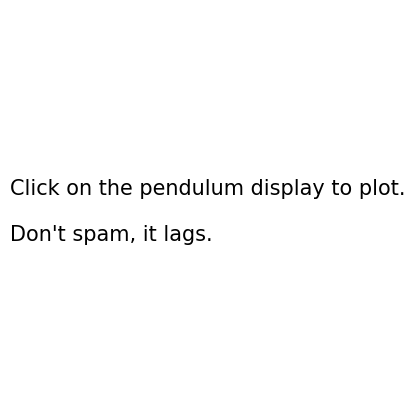

In [7]:
# ==========================================================================================
# ======================================= MAIN LOGIC =======================================
# ==========================================================================================
qp = np.deg2rad(param.init_qp)
qp_d = param.init_qp_d

qr = param.init_qr  # Initial reaction wheel angle
qr_d = param.init_qr_d  # Initial reaction wheel speed

curr_prev = 0
curr_d = 0

Tm = param.init_Tm  # Initial reaction wheel torque
Tp = param.init_Tp  # Initial disturbance torque

controller_stat_flag = False
controller_stat_flag_last = False
controller_time = 0
controller_energy = 0

timedt = 0
dt = 1 / 100  # frequency (Hz)
reqE = (m1 + m2) * g * L2 * math.cos(0)

setpoint = 0 # do not adjust

# For LQR control
K, S, E = control.lqr(A_matrix, B_Matrix, Q_LQR, R_LQR, N_LQR)

# For PID control
s = control.TransferFunction.s
G = (s/(-J-m1*L1*L1))/((s**3 + ((B/I1) + (B + dp)/(m2*L2*L2))*s**2 - ((m1*L1 + m2*L2)*g/((J + m2*L2*L2)*I1) - (B + dp)/((J+m2*L2*L2)*I1))*s - (m1*L1 + m2*L2)*B*g/((J+m2*L2*L2)*I1)))
C = 1/s

# Plot the root locus
if param.Stabilize_Controller == "PID" and param.plot_rootlocus:
    print("PID Mode")
    print("Waiting for root locus ...")
    print(G)
    control.rlocus(C*G)
    print("Systemzero: ", control.zero(G))
    print("Systempoles: ", control.pole(G))
    plt.title('Root Locus Plot')
    plt.xlabel('Re')
    plt.ylabel('Im')
    plt.grid(True)
    plt.show()
    print("Initialize simulation")


d_flag = 0

settled_flag = False
wait_flag = False

running = True
input_flag = False
input_string = ""

pygame.init()

width, height = 400, 560
screen = pygame.display.set_mode((width, height))
pygame.display.set_caption("Reaction Wheel Inverted Pendulum")
pygame_windows = gw.getWindowsWithTitle("Reaction Wheel Inverted Pendulum")

WHITE = (255, 255, 255)
GREY = (100, 100, 100)
RED = (255, 0, 0)
BLACK = (0, 0, 0)

font = pygame.font.Font(None, 36)
clock = pygame.time.Clock()


app = QApplication(sys.argv)
win = QMainWindow()
win.setWindowFlag(Qt.FramelessWindowHint)  # Remove the title bar
fig = plt.figure(num="plot output", figsize=(5, 5))
plt.text(0, 0.4, "Click on the pendulum display to plot.\n\nDon't spam, it lags.", fontsize = 15)
plt.axis('off')
canvas = FigureCanvas(fig)
win.setCentralWidget(canvas)
win.show()
plt.gcf().canvas.mpl_connect('button_press_event', on_click)
timedt_data = []
qp_data = []
setpoint_data = []
Tm_data = []
qr_d_data = []

while running:
    for event in pygame.event.get():
        if event.type == QUIT:
            running = False
        elif event.type == MOUSEBUTTONDOWN:
            if 10 < event.pos[0] < 110 and 10 < event.pos[1] < 60:
                input_flag = True
            if 292 < event.pos[0] < 392 and 10 < event.pos[1] < 60:
                qp = np.deg2rad(param.init_qp)
                qp_d = param.init_qp_d 
                qr = param.init_qr
                qr_d = param.init_qr_d
                Tm = 0
                Tp = 0
                settled_flag = False
                wait_flag = False
                timedt = 0 
                timedt_data = []
                qp_data = []
                setpoint_data = []
                Tm_data = []
                qr_d_data = []
                controller_time = 0
                controller_energy = 0
            if event.pos[1] > 160:
                plot_graph()
        elif event.type == KEYDOWN:
            if event.key == pygame.K_BACKSPACE:
                input_string = input_string[:-1]
            elif event.key == pygame.K_RETURN:
                input_flag = True
            else:
                input_string += event.unicode

    if input_flag == True:
        try:
            Tp = -float(input_string)
        except:
            Tp = 0
            input_string = ""
        input_flag = False
    else:
        Tp = 0

    # ==========================================================================================
    # ======================================= Controller =======================================
    # ==========================================================================================
    setpoint_offset = (qp - math.pi) / (2 * math.pi)
    if setpoint_offset < 0:
        setpoint = (math.floor(setpoint_offset) + 1) * 2 * math.pi
    elif setpoint_offset > 0:
        setpoint = math.ceil(setpoint_offset) * 2 * math.pi

    E = PendulumEnergy(q=qp)

    if wait_flag:
        controller_mode = "brake"
        if abs(E) < 0.05:
            wait_flag = False
    elif abs(qp) % (2 * math.pi) <= np.deg2rad(StabilizeBound) or abs(qp) % (2 * math.pi) >= np.deg2rad(360 - StabilizeBound):
        settled_flag = True
        controller_mode = param.Stabilize_Controller
        controller_stat_flag = True
    else:
        if settled_flag:
            wait_flag = True
            settled_flag = False
        if not wait_flag:
            controller_mode = "Bang-bang"

    if controller_mode == "LQR":
        e = setpoint - qp
        Vin = e * K[0, 0] + qp_d * -K[0, 1]
    elif controller_mode == "PID":
        e = setpoint - qp
        Vin = -e * param.Kp
    elif controller_mode == "Bang-bang":
        if (qp_d < 0 and E < reqE) or (qp_d >= 0 and E >= reqE):
            Vin = 12
        elif (qp_d >= 0 and E < reqE) or (qp_d < 0 and E >= reqE):
            Vin = -12
        else:
            Vin = 0
    elif controller_mode == "brake":
        if qp_d < 0:
            Vin = -12
        elif qp_d >= 0:
            Vin = 12
    else:
        Vin = 0
    if param.MotorLimit:
        # Actual Limit
        if Vin > 24:
            Vin = 24
        elif Vin < -24:
            Vin = -24
            
    Tm = MotorDynamics(Vin, dt)
    FREQUENCY = pow(abs(qr_d), 2)
    qp_dd = RwipDynamics(qp, Tm, Tp)
    qp_d = qp_d + (qp_dd * dt)
    qp = qp + (qp_d * dt)

    # Draw background
    screen.fill(WHITE)
    pygame.draw.rect(screen, (24, 24, 24), (0, 0, 401, 160))

    # Draw grid
    for i in range(0, 401, 50):
        pygame.draw.line(screen, GREY, (i, 160), (i, 600), 1)
    for i in range(160, 560, 50):
        pygame.draw.line(screen, GREY, (0, i), (400, i), 1)

    # Draw figure
    plot_figure(screen, qp, qp_d, qr_d, Tm, Vin, Tp, setpoint)
    timedt_data.append(timedt)
    qp_data.append(qp)
    setpoint_data.append(setpoint)
    Tm_data.append(Tm)
    qr_d_data.append(qr_d)

    # move graph with pygame
    win.move(pygame_windows[0].left + 420, pygame_windows[0].top + 50)
    win.showNormal()

    # Draw button
    pygame.draw.rect(screen, GREY, (10, 10, 100, 50))
    text = font.render("INJECT", True, WHITE)
    screen.blit(text, (20, 23))
    pygame.draw.rect(screen, RED, (292, 10, 100, 50))
    text = font.render("RESET", True, (255, 255, 255))
    screen.blit(text, (303, 23))

    # Draw disturbance input field
    pygame.draw.rect(screen, GREY, (110, 10, 130, 50))
    pygame.draw.rect(screen, WHITE, (125, 20, 100, 30))
    text = font.render(input_string, True, (0, 0, 0))
    screen.blit(text, (130, 25))

    # calculate FPS and draw
    fps = clock.get_fps()
    timedt += dt
    if(abs(np.rad2deg(qp) - np.rad2deg(setpoint)) < 0.1):
        controller_stat_flag = False
    elif(controller_stat_flag):
        controller_time += dt
        controller_energy += abs(qr_d * Tm) * dt
    if(controller_mode != param.Stabilize_Controller or not controller_stat_flag_last and controller_stat_flag and (abs(np.rad2deg(qp) - np.rad2deg(setpoint)) < 0.1)):
        controller_time = 0
        controller_energy = 0
    controller_stat_flag_last = controller_stat_flag
    if fps:
        dt = 1 / fps

    pygame.display.flip()
    clock.tick(165)

pygame.quit()
stop_thread = True
sys.exit()